# **<center> Predicción del rendimiento académico estudiantil </br> Clasificacion utilizando Random Forest </center>**
<h6>
    <center> Miguel Angel Macias, Jhon Flores <br/> 
    <i>Universidad de Cuenca <br/>  <i>Facultad de Ingenieria - Escuela de Sistemas<br/> Cuenca, Ecuador</i>
    <br/> { mangel.maciasn, jhon.flores }@ucuenca.edu.ec</center>
<h6>

## **1.&emsp; Import**
>Comenzamos importando todas las herramientas que vamos a utilizar para la manejo de los datos y entrenar el modelo para la clasificacion. Se cargan en memoria 5 tablas .csv sin manipular y 2 tablas .csv previamente tratadas.

In [407]:
import numpy as np              # Para operaciones matematicas
import pandas as pd             # Manejo de datos / dataframes
from sys import getsizeof       # Operaciones de sistema
import matplotlib.pyplot as plt #
import seaborn as sns           #

from sklearn.preprocessing import MinMaxScaler            #
from sklearn.model_selection import train_test_split      #
from sklearn.ensemble import RandomForestClassifier       # Modelo RFC
from sklearn import metrics                               # 

from sklearn.model_selection import cross_val_score, GridSearchCV

%matplotlib inline

In [408]:
data_raw = '../data/raw'              # directorio que contiene toda la data sin manipular
data_processed = '../data/processed'  # directorio que contiene data procesada

#### **1.2.&emsp; Dataset df_students**
>Contiene el registro de los datos demográficos y de comportamiento de los estudiante de dos materias de un colegio en Portugal. Los valores categorixos estan convertidos a numericos y contiene una columna "class" que muestra si un estudiente aprueba (1) y reprueba (0) las materia.

In [409]:
df_students = pd.read_csv(data_processed+"/df_students.csv")
df_students.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,class
0,0,0,18,1,0,0,4,4,0,4,...,3,4,1,1,3,6,5,6,6,0
1,0,0,17,1,0,1,1,1,0,2,...,3,3,1,1,3,4,5,5,6,0
2,0,0,15,1,1,1,1,1,0,2,...,3,2,2,3,3,10,7,8,10,0
3,0,0,15,1,0,1,4,2,1,3,...,2,2,1,1,5,2,15,14,15,1
4,0,0,16,1,0,1,3,3,2,2,...,3,2,1,2,5,4,6,10,10,0


In [410]:
df_students.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'class'],
      dtype='object')

## **2.&emsp; Modelo Random Forest (Clasificacion)**
Ahora se construira un modelo con el dataset previamente mencionado. Para el modelo se tomaron en cuenta columnas que aportan al modelo que fueron obtenidas en el EDA por medio de los Feature selection. El modelo contruido sera para clasificar si un estudiante apreueba (1) o reprueba (0) la materia. A continuacion se muestra cuales son las caracteristicas para el modelo:
>- failures - número de fallas de clases pasadas (numeric: n if 1<=n<3, else 4)
- schoolsup - apoyo educativo adicional (binary: yes or no)
- paid - clases pagas adicionales dentro de la asignatura (Math or Portuguese) (binary: yes or no)
- nursery - asistió a la enfermería (binary: yes or no)
- freetime - tiempo libre después de la escuela (numeric: from 1 - very low to 5 - very high)
- Dalc - consumo de alcohol en la jornada laboral (numeric: from 1 - very low to 5 - very high)
- absences - número de ausencias escolares (numeric: from 0 to 93)
- studytime - tiempo de estudio semanal (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
- goout - salir con amigos (numeric: from 1 - very low to 5 - very high)
- G1 - calificación del primer período (numeric: from 0 to 20)

#### **2.1.&emsp; Separacion de conjunto de Estrenamiento y Prueba**
>Separamos las caractertisticas en variables dependientes e independientes. Luego esas variables se dividiran en un conjunto de entrenamiento y prueba.

In [411]:
# failures, schoolsup, paid, nursery, freetime, Dalc, absences, studytime, goout, G1
X = df_students[["failures", "schoolsup", "paid", "nursery",
                 "freetime", "Dalc", "absences", "studytime", "goout", "G1"]]
y = df_students['class']

# Split dataset into training set and test set
scaler = MinMaxScaler()
tmp = scaler.fit_transform(X)
X = pd.DataFrame(tmp, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

#### **2.2.&emsp; Entrenamiento del Modelo**

###### **2.2.1.&emsp; Tuning de Hyperparametros**
>Se realizara un tuneo de los hyperparametros del modelo para obtener un mejor resultado.

In [412]:
# NOTA: Se demora al ejecutar
# Perform Grid-Search
"""
clf = RandomForestClassifier(random_state=42)

parameters = {
    "max_depth": [10, 50, 80, 90, 100, 110],
    "max_leaf_nodes": [10, 50, 75, 100],
    "min_samples_split": [2, 3, 4],
    "n_estimators": [10, 50, 100],
    "min_samples_leaf": [1, 2, 5, 10],
    "bootstrap": [True, False]
}

# clf_svc = RandomizedSearchCV(clf_svc, param_distributions=parameters, scoring="accuracy", cv=5, n_jobs=-1, n_iter=15)
clf = GridSearchCV(clf, param_grid=parameters, scoring="accuracy", cv=5, n_jobs=-1)
model_rf = clf.fit(X_train, y_train)

#print ("R2 score:", r2(y_test,y_predict))
print("Best score : ", model_rf.best_score_)
print("Best Parameters : ", model_rf.best_params_)
#print("Accuracy Score : ", accuracy_score(model_svc.predict(X_test), y_test))
print("Training Accuracy : ", model_rf.score(X_train, y_train))
print("Test Accuracy : ", model_rf.score(X_test, y_test))
"""

'\nclf = RandomForestClassifier(random_state=42)\n\nparameters = {\n    "max_depth": [10, 50, 80, 90, 100, 110],\n    "max_leaf_nodes": [10, 50, 75, 100],\n    "min_samples_split": [2, 3, 4],\n    "n_estimators": [10, 50, 100],\n    "min_samples_leaf": [1, 2, 5, 10],\n    "bootstrap": [True, False]\n}\n\n# clf_svc = RandomizedSearchCV(clf_svc, param_distributions=parameters, scoring="accuracy", cv=5, n_jobs=-1, n_iter=15)\nclf = GridSearchCV(clf, param_grid=parameters, scoring="accuracy", cv=5, n_jobs=-1)\nmodel_rf = clf.fit(X_train, y_train)\n\n#print ("R2 score:", r2(y_test,y_predict))\nprint("Best score : ", model_rf.best_score_)\nprint("Best Parameters : ", model_rf.best_params_)\n#print("Accuracy Score : ", accuracy_score(model_svc.predict(X_test), y_test))\nprint("Training Accuracy : ", model_rf.score(X_train, y_train))\nprint("Test Accuracy : ", model_rf.score(X_test, y_test))\n'

>Ahora, se entrena el modelo en el conjunto de entrenamiento. Luego se realizará predicciones en el conjunto de prueba que se tiene previamente. Luego, se verifica la precisión utilizando valores reales y pronosticados.

In [413]:
clf = RandomForestClassifier(bootstrap=False, max_depth=10, max_leaf_nodes=10, min_samples_leaf=10,
                             min_samples_split=2, n_estimators=50, random_state=42)
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
print("Prediction Random Forest: {:.3f}".format(metrics.accuracy_score(y_pred,y_test)))

Prediction Random Forest: 0.850


In [414]:
print("Training score: ", clf.score(X_train, y_train))
print("Test score: ", clf.score(X_test, y_test))

Training score:  0.8917808219178082
Test score:  0.8503184713375797


## **3.&emsp; Evaluacion del Modelo Random Forest (Clasificacion)**
Ya realizado la prediccion de que si los estudiantes aprobaron o no la materia, lo que se realizara ahora es comparar los valores de la prediccion con los datos reales.

#### **3.1.&emsp; Evaluacion sin seleccion de carateristicas importantes**
>Contenido

###### **3.1.1.&emsp; Creacion Matriz de Confusion**
>En esta matriz 

In [415]:
pd.crosstab(y_test, y_pred, rownames=['Datos Actuales'], colnames=['Datos Predichos'])

Datos Predichos,0,1
Datos Actuales,,
0,80,29
1,18,187


Confusion matrix, without normalization
[[ 80  29]
 [ 18 187]]


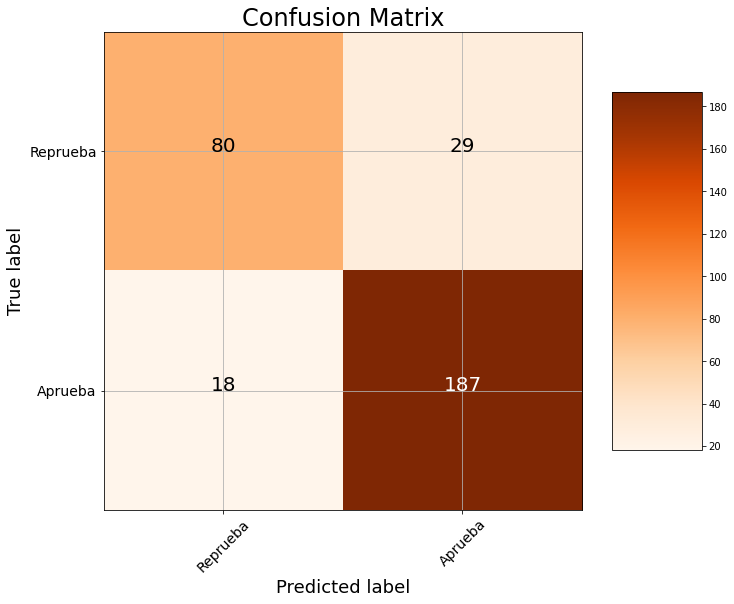

In [416]:
from sklearn.metrics import confusion_matrix
import itertools
#plt.style.use('fivethirtyeight')
#plt.rcParams['font.size'] = 18

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['Reprueba', 'Aprueba'],
                      title = 'Confusion Matrix')

###### **3.1.2.&emsp; ROC AUC (área de características operativas del receptor bajo la curva)**

Recall Baseline: 1.0 Test: 0.91 Train: 0.93
Precision Baseline: 0.65 Test: 0.87 Train: 0.9
Roc Baseline: 0.5 Test: 0.94 Train: 0.95


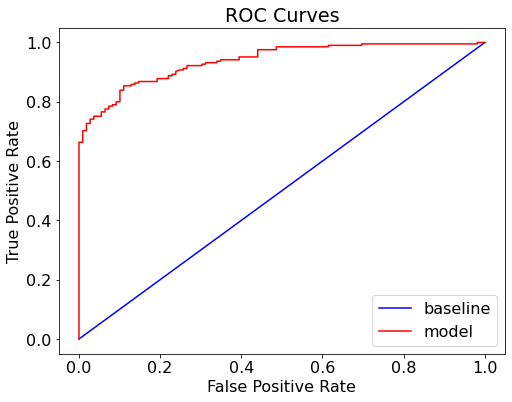

In [417]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Training predictions (to demonstrate overfitting)
train_rf_predictions = clf.predict(X_train)
train_rf_probs = clf.predict_proba(X_train)[:, 1]

# Testing predictions (to determine performance)
rf_predictions = clf.predict(X_test)
rf_probs = clf.predict_proba(X_test)[:, 1]

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, 
                                     [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, 
                                      [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

###### **3.1.3.&emsp; Clasification Report**

In [418]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[ 80  29]
 [ 18 187]]
              precision    recall  f1-score   support

           0       0.82      0.73      0.77       109
           1       0.87      0.91      0.89       205

    accuracy                           0.85       314
   macro avg       0.84      0.82      0.83       314
weighted avg       0.85      0.85      0.85       314

0.8503184713375797


#### **3.2.&emsp; Caracteritsticas Importantes**
>Se va a obtener las caracteristicas importantes del conjunto de datos del dataset. Primero se debe crear un modelo de bosque aleatorio; luego, usar el feature_importances_ para ver la importancia de las caracteristicas. Luego se visualizaran los resultados de cada caracteristica.

In [419]:
df_students_plot = df_students[["failures", "schoolsup", "paid", "nursery",
                           "freetime", "Dalc", "absences", "studytime",
                           "goout", "G1"]]

In [420]:
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

No handles with labels found to put in legend.


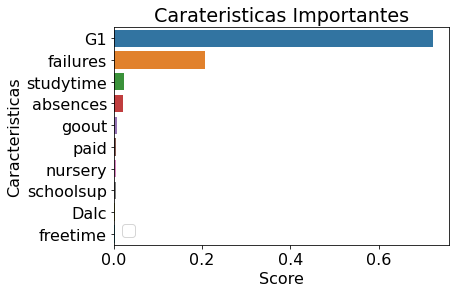

In [421]:
feature_imp = pd.Series(clf.feature_importances_,index = df_students_plot.columns).sort_values(ascending=False)

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Score')
plt.ylabel('Caracteristicas')
plt.title("Carateristicas Importantes")
plt.legend()
plt.show()

###### **3.2.1.&emsp; Generando el modelo con las Caracteristicas Seleccionadas**
>En este caso se van a usar las caracteristicas G1, failures, absences, studytime para general el nuevo modelo.

In [422]:
# failures, schoolsup, paid, nursery, freetime, Dalc, absences, studytime, goout, G1
X = df_students[["failures", "absences", "studytime", "G1"]]
y = df_students['class']

# Split dataset into training set and test set
scaler = MinMaxScaler()
tmp = scaler.fit_transform(X)
X = pd.DataFrame(tmp, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

>Ahora, se entrena el modelo en el conjunto de entrenamiento. Luego se realizará predicciones en el conjunto de prueba que se tiene previamente. Luego, se verifica la precisión utilizando valores reales y pronosticados.

In [423]:
clf = RandomForestClassifier(bootstrap=False, max_depth=10, max_leaf_nodes=10, min_samples_leaf=10,
                             min_samples_split=2, n_estimators=50, random_state=42)
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
print("Prediction Random Forest: {:.3f}".format(metrics.accuracy_score(y_pred,y_test)))

Prediction Random Forest: 0.847


In [424]:
print("Training score: ", clf.score(X_train, y_train))
print("Test score: ", clf.score(X_test, y_test))

Training score:  0.8698630136986302
Test score:  0.8471337579617835


#### **3.3.&emsp; Evaluacion con seleccion de carateristicas importantes**
>Ya realizado la prediccion de que si los estudiantes aprobaron o no la materia, lo que se realizara ahora es comparar los valores de la prediccion con los datos reales.

###### **3.3.1.&emsp; Creacion Matriz de Confusion**

In [425]:
pd.crosstab(y_test, y_pred, rownames=['Datos Actuales'], colnames=['Datos Predichos'])

Datos Predichos,0,1
Datos Actuales,,
0,104,14
1,34,162


Confusion matrix, without normalization
[[104  14]
 [ 34 162]]


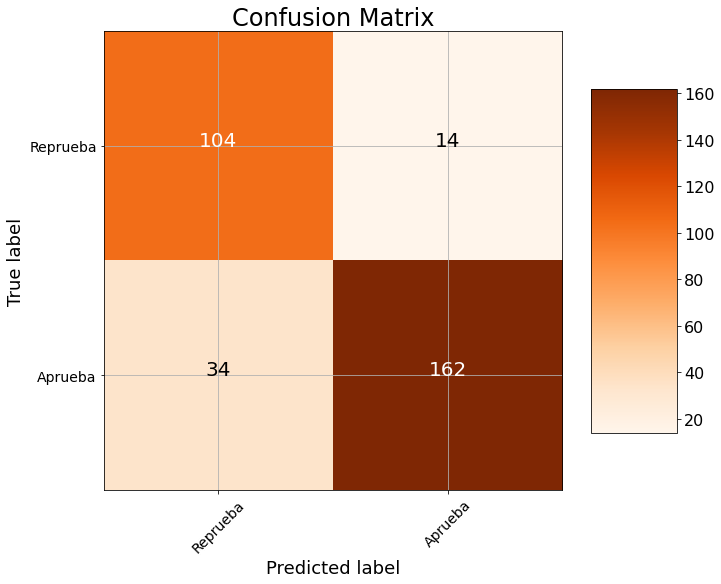

In [426]:
from sklearn.metrics import confusion_matrix
import itertools
#plt.style.use('fivethirtyeight')
#plt.rcParams['font.size'] = 18

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['Reprueba', 'Aprueba'],
                      title = 'Confusion Matrix')

###### **3.3.2.&emsp; ROC AUC (área de características operativas del receptor bajo la curva)**

Recall Baseline: 1.0 Test: 0.83 Train: 0.87
Precision Baseline: 0.62 Test: 0.92 Train: 0.92
Roc Baseline: 0.5 Test: 0.94 Train: 0.95


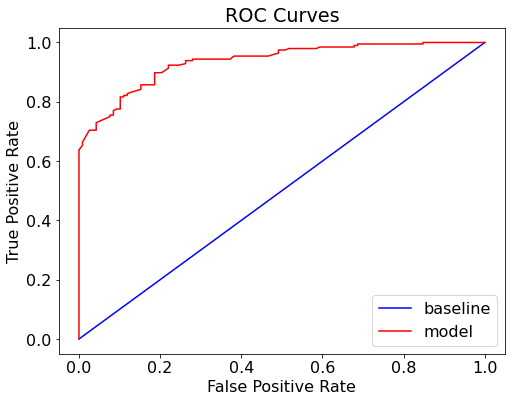

In [427]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Training predictions (to demonstrate overfitting)
train_rf_predictions = clf.predict(X_train)
train_rf_probs = clf.predict_proba(X_train)[:, 1]

# Testing predictions (to determine performance)
rf_predictions = clf.predict(X_test)
rf_probs = clf.predict_proba(X_test)[:, 1]

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, 
                                     [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, 
                                      [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

###### **3.3.3.&emsp; Clasification Report**

In [428]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[104  14]
 [ 34 162]]
              precision    recall  f1-score   support

           0       0.75      0.88      0.81       118
           1       0.92      0.83      0.87       196

    accuracy                           0.85       314
   macro avg       0.84      0.85      0.84       314
weighted avg       0.86      0.85      0.85       314

0.8471337579617835
